In [1]:
# from Model_Function import NeuralNet_ts_predictions
import pywt
import numpy as np,pandas as pd
import matplotlib.pyplot as plt

In [2]:
FML_SHARE_PRICES =pd.read_csv('lstmmodel/To_be_dc.csv')
FML_SHARE_PRICES.set_index('Date', inplace = True )
FML_SHARE_PRICES.head()

,FML
Date,
1990-11-12,0.00250
1990-11-19,0.00250
1990-11-26,0.00250
1990-12-03,0.00250
1990-12-10,0.00245


## Wavelet decomposition
It is really not necessary to decompose the signal into the maximum levels. Normally, it is enough to decompose a signal into 3 to 9 levels. Here, we specify the decomposition level to 6.

In [3]:
coeffs = pywt.wavedec(FML_SHARE_PRICES,'db6','sym',level=6)

(cA6,cD6,cD5,cD4,cD3,cD2,cD1) = coeffs

C:\Users\Benjamin\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


## Print the approximation and detail coefficients
We just print the approximation and detail coefficient at the last level for example.

In [4]:
print('cA6 = ',cA6)
print('cD6 = ',cD6)

cA6 =  [[2.000e-02 2.000e-02 2.000e-02 ... 2.000e-02 2.000e-02 2.000e-02]
 [2.000e-02 2.000e-02 2.000e-02 ... 2.000e-02 2.000e-02 2.000e-02]
 [2.000e-02 2.000e-02 2.000e-02 ... 2.000e-02 2.000e-02 2.000e-02]
 ...
 [2.852e+01 2.852e+01 2.852e+01 ... 2.852e+01 2.852e+01 2.852e+01]
 [2.852e+01 2.852e+01 2.852e+01 ... 2.852e+01 2.852e+01 2.852e+01]
 [2.852e+01 2.852e+01 2.852e+01 ... 2.852e+01 2.852e+01 2.852e+01]]
cD6 =  [[-1.07911997e-18 -1.08420217e-18 -1.08420217e-18 ...  0.00000000e+00
  -9.21571847e-19 -9.35124374e-19]
 [-1.07911997e-18 -1.08420217e-18 -1.08420217e-18 ...  0.00000000e+00
  -9.21571847e-19 -9.35124374e-19]
 [-1.07911997e-18 -1.08420217e-18 -1.08420217e-18 ...  0.00000000e+00
  -9.21571847e-19 -9.35124374e-19]
 ...
 [ 1.04430353e-15 -3.43128304e-15 -4.27782809e-15 ...  4.61436445e-16
   3.77128884e-15 -2.88657986e-15]
 [ 1.04430353e-15 -3.43128304e-15 -4.27782809e-15 ...  4.61436445e-16
   3.77128884e-15 -2.88657986e-15]
 [ 1.04430353e-15 -3.43128304e-15 -4.27782809e-1

## Check the length of the coefficients
Let's check the coefficient length at the last level to compare them with the length of the orignal signal.

In [5]:
print(len(FML_SHARE_PRICES))
print(len(cA6))
print(len(cD6))

1570
1570
1570


## Visualization of Approximation and Details Coefficients
Printing the coefficient values seems no sense, and visualizing them is more meaningful to see what they are like.

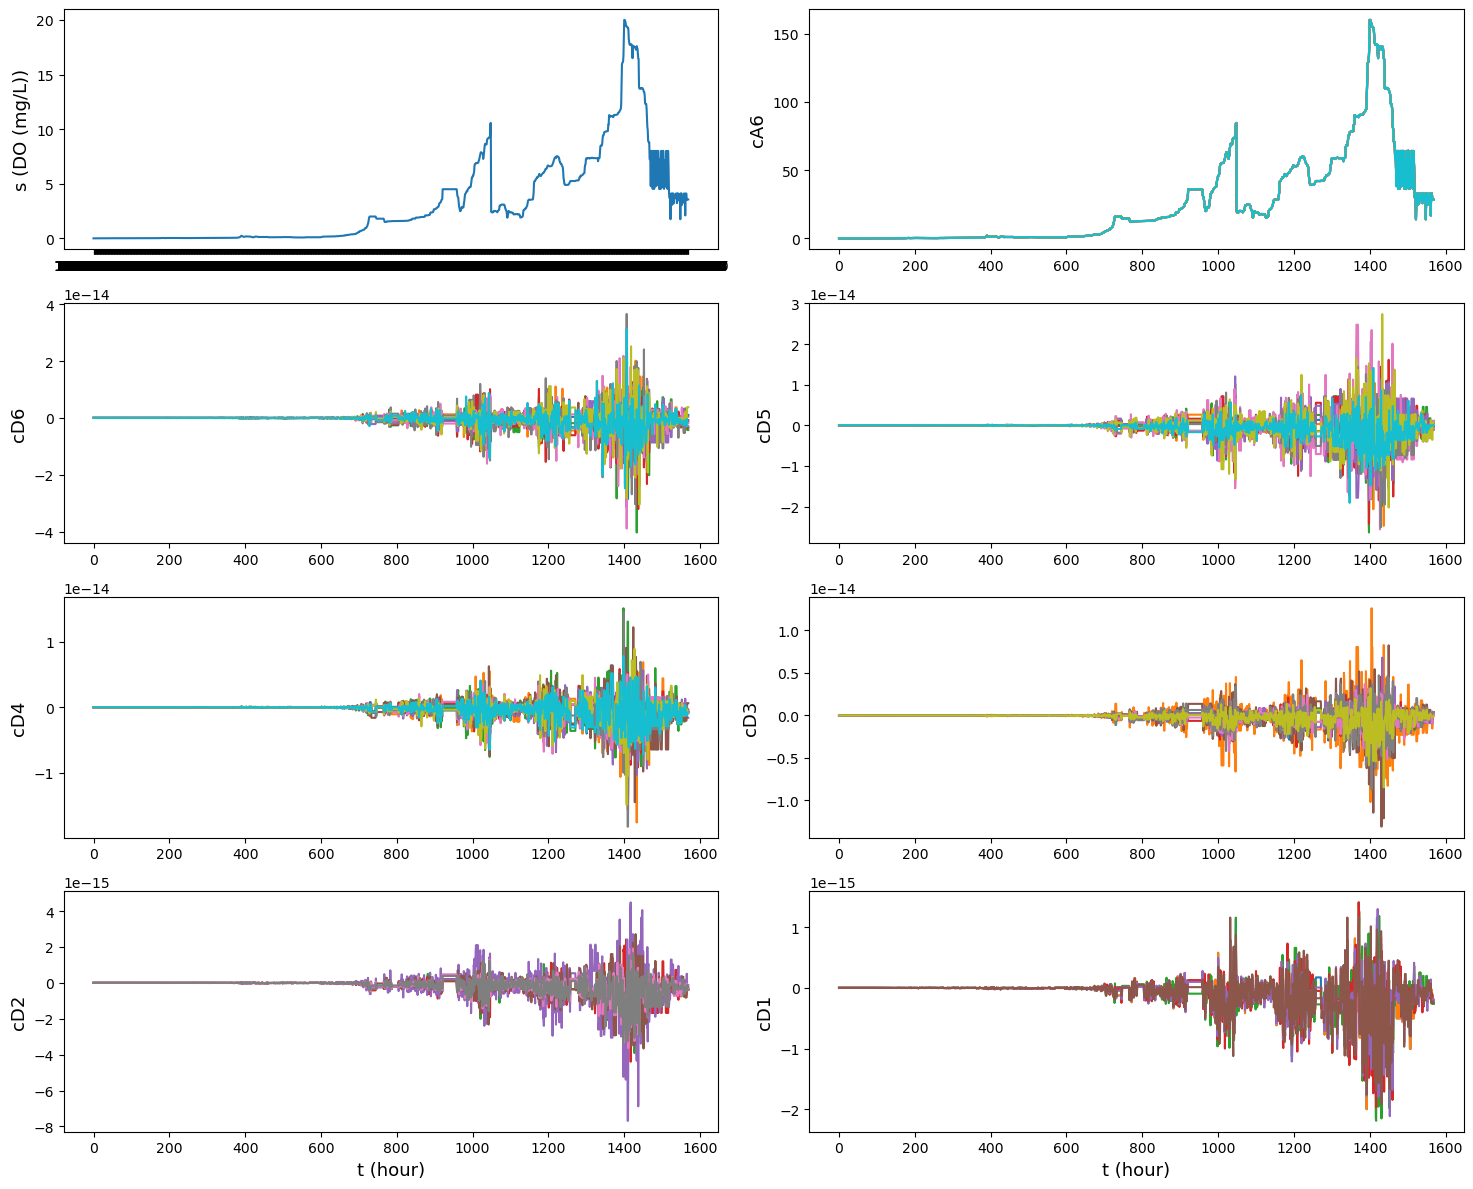

In [6]:
fig,axs = plt.subplots(4,2,figsize=(15,12))

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

axs[0,0].plot(FML_SHARE_PRICES)
axs[0,0].set_ylabel('s (DO (mg/L))',fontsize=13)

axs[0,1].plot(cA6)
axs[0,1].set_ylabel('cA6',fontsize=13)

axs[1,0].plot(cD6)
axs[1,0].set_ylabel('cD6',fontsize=13)

axs[1,1].plot(cD5)
axs[1,1].set_ylabel('cD5',fontsize=13)

axs[2,0].plot(cD4)
axs[2,0].set_ylabel('cD4',fontsize=13)

axs[2,1].plot(cD3)
axs[2,1].set_ylabel('cD3',fontsize=13)

axs[3,0].plot(cD2)
axs[3,0].set_ylabel('cD2',fontsize=13)
axs[3,0].set_xlabel('t (hour)',fontsize=13)

axs[3,1].plot(cD1)
axs[3,1].set_ylabel('cD1',fontsize=13)
axs[3,1].set_xlabel('t (hour)',fontsize=13)

plt.tight_layout()
plt.savefig('./image/water_s_coeffs.png',dpi=300)

plt.show()

## Reconstruct the Signal
In this section, we will reconstruct the signal and compare the reconstructed signal with the original signal in terms of length, plot and errors.

# Reconstruct the signal
Let's see if we can successfully reconstruct the signal from these coefficients.

In [7]:
Reconstruct = pywt.waverec(coeffs,'db6','sym')

Next, we check the length of the reconstructed signal and see if it has the same length with the original signal.

In [8]:
print(len(FML_SHARE_PRICES))
print(len(Reconstruct))

1570
1570


In the wavelet reconstruction method, it has already discussed that the reconstructed signal will have one more value at the end when the original has an odd length. Thus, the real constructed signal is the one excluded the last value.

##  Compare reconstructed signal with the original one
First, we compare them in terms of plot.

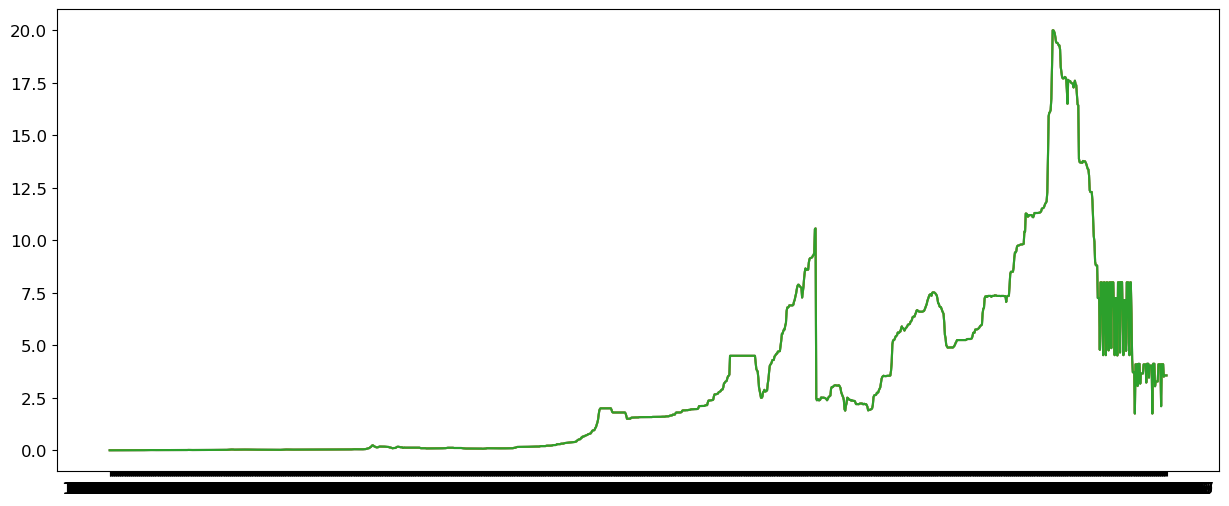

In [9]:

fig,ax = plt.subplots(figsize=(15,6))

ax.plot(FML_SHARE_PRICES)
ax.plot(Reconstruct)

plt.show()

In [10]:
def model_data_setup(data, lookback, delay, min_index, max_index):
    '''
    data:     Shape (n_samples,n_features). First column is the time series, other columns are the features.
    lookback: Number of time steps in the RNN >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x,y) of numpy arrays where x is in shape (n_samples,n_timesteps,n_features) and 
             y is in shape (n_samples,delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    '''
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
                  
    samp, targ = [], []
    for i in range(n_samples):  
        indices1 = range(i, i+lookback)
        indices2 = range(i + lookback, i + lookback + delay)
        samples[i] = data[indices1]
        targets[i,:] = data[indices2][0:delay][:,0] 
        #print(samples,targets)
    samp.append(samples);targ.append(targets)

    return np.array(samp)[0],np.array(targ)[0]

In [11]:
lookback =4 #Rolling period/ window of 5 and 10 weeks was used
delay = 1
min_index = 0
max_index = Reconstruct.shape[0]-1
xdata, ydata = model_data_setup(Reconstruct, lookback, delay, min_index, max_index)
print('The shape of the input sample set is: ',  xdata.shape)
print('The shape of the target set is: ', ydata.shape)

The shape of the input sample set is:  (1566, 4, 2)
The shape of the target set is:  (1566, 1)


In [12]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(Reconstruct)*0.6) # 2416#
valid_size = int(len(Reconstruct)*0.2) #605#
test_size = len(Reconstruct) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = Reconstruct[0:train_size,:], Reconstruct[train_size:train_size+valid_size,:], Reconstruct[train_size+valid_size:len(Reconstruct),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (942, 2)
The shape of the validation sample is:  (314, 2)
The shape of the testing sample is:  (314, 2)
The shape of the training target is:  (942, 1)
The shape of the validation target is:  (314, 1)
The shape of the testing target is:  (310, 1)


In [13]:
n_features = Reconstruct.shape[1]
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np


# Define the LSTM model
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(32, activation='tanh',
                input_shape = (1,n_features),
                return_sequences = True))#,recurrent_dropout=0.3))

LSTM_Model.add(Dense(1))
opt = Adam(learning_rate=0.02)#, decay=1e-6)
LSTM_Model.compile(loss='mse', optimizer=opt , metrics=["mae"])
LSTM_Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 32)             4480      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


we are going to use a hybrid model that combines three different techniques: wavelet transform (WT), long short-term memory (LSTM), and an adaptive genetic algorithm (AGA) and compare it to ARIMA, SARIMA, and Prophet

First, we will use the wavelet transform (WT) to decompose the time series into multiple scales or sub-series. The purpose of this is to capture different levels of variability and trends in the time series. We can use the pywt package to perform the wavelet transform.

Next, we will use the long short-term memory (LSTM) neural network to model the sub-series at each scale. LSTM is a type of recurrent neural network that is well-suited for time series forecasting because it can capture long-term dependencies and patterns in the data. We can use the Keras API in TensorFlow to implement the LSTM.

Finally, we will use an adaptive genetic algorithm (AGA) to optimize the hyperparameters of the LSTM model. The AGA is a type of evolutionary algorithm that can search for the best set of hyperparameters to maximize the forecasting accuracy. We can use the DEAP package to implement the AGA.

Here are the general steps to build the hybrid model:

Perform wavelet transform on the time series to decompose it into multiple scales.
For each scale, prepare the data for LSTM modeling (e.g., split into training and test sets, normalize the data).
Train an LSTM model on each scale using the training data and validate the model using the test data.
Use an AGA to optimize the hyperparameters of each LSTM model.
Combine the predictions from all LSTM models to obtain the final forecast.

In [19]:
np.random.seed(123)
history_2=LSTM_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=100, verbose=1)

Epoch 1/100


ValueError: in user code:

    File "C:\Users\Benjamin\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Benjamin\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Benjamin\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Benjamin\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Benjamin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Benjamin\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 1, 2), found shape=(None, 2)
